In [15]:
import torch
from torch import nn

from tqdm import tqdm
from itertools import chain
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

from torch.optim.lr_scheduler import StepLR

import os
import random

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
LSTM_PATH="/content/drive/MyDrive/LSTM/model/Univariate-SingleStep-LSTM-2.pkl"

In [20]:
def load_data(file_name):
    global MAX, MIN
    df = pd.read_csv('/content/drive/MyDrive/LSTM/data/' + file_name, encoding='gbk')
    columns = df.columns
    df.fillna(df.mean(), inplace=True)
    MAX = np.max(df[columns[1]])
    MIN = np.min(df[columns[1]])
    df[columns[1]] = (df[columns[1]] - MIN) / (MAX - MIN)

    return df


class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)
    
    
def nn_seq(file_name, B):
    print('Data processing:')
    data = load_data(file_name)
    load = data[data.columns[1]]
    load = load.tolist()
    load = torch.FloatTensor(load).view(-1)
    data = data.values.tolist()
    seq = []
    for i in range(len(data) - 24):
        train_seq = []
        train_label = []
        for j in range(i, i + 24):
            train_seq.append(load[j])
        train_label.append(load[i + 24])
        train_seq = torch.FloatTensor(train_seq).view(-1)
        train_label = torch.FloatTensor(train_label).view(-1)
        seq.append((train_seq, train_label))
    # print(seq[:5])

    Dtr = seq[0:int(len(seq) * 0.7)]
    Dte = seq[int(len(seq) * 0.7):len(seq)]

    train_len = int(len(Dtr) / B) * B
    test_len = int(len(Dte) / B) * B
    Dtr, Dte = Dtr[:train_len], Dte[:test_len]

    train = MyDataset(Dtr)
    test = MyDataset(Dte)

   
    Dtr = DataLoader(dataset=train, batch_size=B, shuffle=False, num_workers=0)
    Dte = DataLoader(dataset=test, batch_size=B, shuffle=False, num_workers=0)

    return Dtr, Dte


In [ ]:
# epoch
# batch
# batch_size
# Learn the role of dataLoader
# Learn what an iterator is and how to use it

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 #unidirectional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        seq_len = input_seq.shape[1] # (5, 24)
        # input(batch_size, seq_len, input_size)
        input_seq = input_seq.view(self.batch_size, seq_len, 1)  # (5, 24, 1)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq, (h_0, c_0)) # output(5, 24, 32)
        output = output.contiguous().view(self.batch_size * seq_len, self.hidden_size) # (5 * 24, 32)
        pred = self.linear(output) # pred(120, 1)
        pred = pred.view(self.batch_size, seq_len, -1) # (5, 24, 1)
        pred = pred[:, -1, :]  # (5, 1)
        return pred


In [25]:
def LSTM_train(name, b):
    Dtr, Dte = nn_seq(file_name=name, B=b)
    input_size, hidden_size, num_layers, output_size = 1, 32, 2, 1
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=b).to(device)
    loss_function = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # training
    epochs = 1
    cnt = 0
    for i in range(epochs):
        cnt = 0
        print('Cur', i)
        for (seq, label) in Dtr:
            cnt += 1
            seq = seq.to(device)
            label = label.to(device)
            # forward 
            y_pred = model(seq)
            # loss
            loss = loss_function(y_pred, label)
            # Calculate the gradient.
            optimizer.zero_grad()
            # Backpropagation, update parameters.
            loss.backward()
            optimizer.step()
            if cnt % 1000 == 0:
                print('epoch', i, ':', cnt - 1000, '~', cnt, loss.item())
    state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, LSTM_PATH)


In [26]:
LSTM_train("data.csv", 5)

Data processing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


Cur 0
epoch 0 : 900 ~ 1000 0.003596266033127904
epoch 0 : 1900 ~ 2000 0.0035313803236931562
epoch 0 : 2900 ~ 3000 0.004085303284227848


In [27]:
def get_mape(x, y):
    """
    :param x: true value
    :param y: pred value
    :return: mape
    """
    return np.mean(np.abs((x - y) / x))

In [28]:
def test(name, b):
    global MAX, MIN
    Dtr, Dte = nn_seq(file_name=name, B=b)
    pred = []
    y = []
    print('loading model...')
    input_size, hidden_size, num_layers, output_size = 1, 32, 2, 1
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=b).to(device)
    model.load_state_dict(torch.load(LSTM_PATH)['model'])
    model.eval()
    print('predicting...')
    for (seq, target) in Dte:
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        seq_len = seq.shape[1]
        seq = seq.view(model.batch_size, seq_len, 1)  # (5, 24, 1)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (MAX - MIN) * y + MIN
    pred = (MAX - MIN) * pred + MIN
    print('accuracy:', get_mape(y, pred))
    # plot
    x = [i for i in range(1, 151)]
    x_smooth = np.linspace(np.min(x), np.max(x), 600)
    y_smooth = make_interp_spline(x, y[0:150])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    y_smooth = make_interp_spline(x, pred[0:150])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    plt.show()


Data processing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


loading model...
predicting...
accuracy: 0.07257110117477293


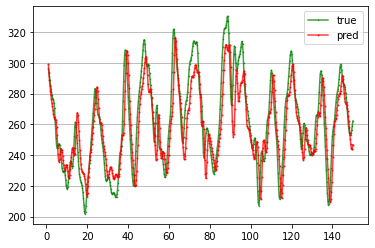

In [29]:
test("data.csv", 6)